In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from ccdproc import Combiner
from ccdproc import wcs_project

import inspect
import importlib

# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import downloader 
import refcat
import imagehandler

importlib.reload(downloader)
importlib.reload(refcat)
importlib.reload(imagehandler)

<module 'imagehandler' from '/home/mikea/GitHub/shifty/shifty/imagehandler.py'>

# OneImage
This class exists for dealing with individual images. 
Currently its functionality is pretty limited, so I'm not convinced it needs to be a seperate class, as the functionality could just get rolled in to ImageEnsemble.
But maybe we'll add more to it that will be valuable to have on a per-image basis.

Start by initializing the class with a filename. 

In [2]:
filename = '../dev_data/2015RS281_HSC20160826_123.fits'
one=imagehandler.OneImage(filename)

Set DATE-END to '2016-08-27T15:03:43.582' from MJD-END'. [astropy.wcs.wcs]


The initialization can be given additional keywords:

        extno          - int          - Extension number of image data
                                      - (0 if single-extension)
                                      - default is 0
        verbose        - bool         - Print extra stuff if True
                                      - default is False
        EXPTIME        - str OR float - Exposure time in seconds
                                      - (keyword or value)
                                      - default is 'EXPTIME'
        MAGZERO        - str OR float - Zeropoint magnitude
                                      - (keyword or value)
                                      - default is 'MAGZERO'
        MJD_START      - str OR float - MJD at start of exposure
                                      - (keyword or value)
                                      - default is 'MJD-STR'
        GAIN           - str OR float - Gain value (keyword or value)
                                      - default is 'GAINEFF'
        FILTER         - str          - Filter name (keyword)
                                      - default is 'FILTER'
        NAXIS1         - str OR int   - Number of pixels along axis 1
                                      - default is 'NAXIS1'
        NAXIS2         - str OR int   - Number of pixels along axis 2
                                      - default is 'NAXIS2'
        INSTRUMENT     - str          - Instrument name (keyword)
                                      - default is 'INSTRUME'
Most of this is probably not actually needed, but I figured that for now it would be good to have handy any header values that we _might_ need. 

The _one_ object should now have a few attributes:

In [3]:
[key for key in one.__dict__.keys()]

['local_dir',
 'readOneImageAndHeader',
 'key_values',
 'header_keywords',
 'WCS',
 'header',
 'header0',
 'data',
 'filename',
 'extno']

- _readOneImageAndHeader_ is the function used for reading a file. It's available here as a pseudo-method, in case a new file should get read in or the object was initialized without a filename.
- _header_keywords_ is a dictionary connecting the specified names of keywords to their default names.
- _key_values_ is a dictionary with the values of the header keywords
- _WCS_ is the WCS
- _header_ is the entire header of the image extension
- _header0_ is the entire main header (multi-extension fits often have some info, like WCS, in individual extension headers and other info, like exposure time, in the main header in extension 0).
- _data_ is a 2D numpy array with the pixel data
- _filename_ remembers the input filename
- _extno_ remembers the input extension number

one.extno: 0
one.filename: ../dev_data/2015RS281_HSC20160826_123.fits
Data shape: (4176, 2048), 3x3 cutout:
[[ 20.243996    4.0346475  12.30828  ]
 [ 20.336226  -12.07893     7.6109095]
 [ 15.043001   -9.811708   13.259375 ]]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6441564916312  6.6288219094174  
CRPIX : 1004.45266198922  -4724.91106031561  
CD1_1 CD1_2  : 2.2977150732699e-08  -4.68807303104328e-05  
CD2_1 CD2_2  : -4.68825893935184e-05  -1.86575264084819e-08  
NAXIS : 2048  4176

one.header_keywords content:
('EXPTIME', 'EXPTIME')
('MAGZERO', 'MAGZERO')
('MJD_START', 'MJD-STR')
('GAIN', 'GAINEFF')
('FILTER', 'FILTER')
('NAXIS1', 'NAXIS1')
('NAXIS2', 'NAXIS2')
('INSTRUMENT', 'INSTRUME')

one.key_values content:
('EXPTIME', 300.0)
('MAGZERO', 27.0554836676559)
('MJD_START', 57627.62409255)
('GAIN', 3.59751856327057)
('FILTER', 'r')
('NAXIS1', 2048)
('NAXIS2', 4176)
('INSTRUMENT', 'Hyper Suprime-Cam')
('MJD_MID', 57627.62582866111)


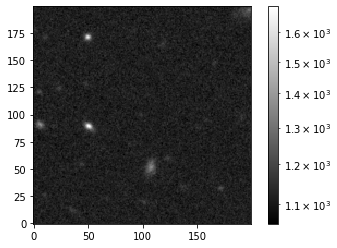

In [4]:
print(f"one.extno: {one.extno}")
print(f"one.filename: {one.filename}")
print(f"Data shape: {one.data.shape}, 3x3 cutout:")
print(one.data[81:84,81:84])
print("")
print(one.WCS)
print(f"\none.header_keywords content:")
_ = [print(o) for o in one.header_keywords.items()]
print(f"\none.key_values content:")
_ = [print(o) for o in one.key_values.items()]
plt.imshow((one.data-one.data.min())[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

# ImageEnsemble
This class is used for accumulating information about a whole set of associated images. 
It contains these methods:
- reproject_data - for aligning (by reprojection) images to a shared WCS. Optional step.
- integer_shift - shift image data by an integer number of pixels. 
- stack - stacks all the data arrays, either shifted or non-shifted (keyword controlled).
- save_stack - saves a stacked array to a fits file.

In [5]:
# I'm gonna define this flag, so that it's easy to switch between
# using both nights (24 images) and just the second night (12 images).
# Only the last 12 images are in GitHub repo.
both_nights=False

First make a list of filenames:

In [6]:
filename = '../dev_data/2015RS281_HSC20160826_112.fits'
if both_nights:
    filenames=[filename.replace('100', str(i)) for i in np.arange(100, 124)]
    filenames[-12:]=[filenamei.replace('0825', '0826') for filenamei in filenames[-12:]]
else:
    filenames=[filename.replace('112', str(i)) for i in np.arange(112, 124)]

filenames

['../dev_data/2015RS281_HSC20160826_112.fits',
 '../dev_data/2015RS281_HSC20160826_113.fits',
 '../dev_data/2015RS281_HSC20160826_114.fits',
 '../dev_data/2015RS281_HSC20160826_115.fits',
 '../dev_data/2015RS281_HSC20160826_116.fits',
 '../dev_data/2015RS281_HSC20160826_117.fits',
 '../dev_data/2015RS281_HSC20160826_118.fits',
 '../dev_data/2015RS281_HSC20160826_119.fits',
 '../dev_data/2015RS281_HSC20160826_120.fits',
 '../dev_data/2015RS281_HSC20160826_121.fits',
 '../dev_data/2015RS281_HSC20160826_122.fits',
 '../dev_data/2015RS281_HSC20160826_123.fits']

Initialize with the list of filenames:

In [7]:
importlib.reload(imagehandler)
E=imagehandler.ImageEnsemble(filenames)

Set DATE-END to '2016-08-27T08:48:02.183' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T09:10:43.817' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T09:46:01.793' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T10:20:20.272' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T10:54:59.827' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T11:29:56.093' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T12:05:01.678' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T12:40:54.900' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T13:17:21.200' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T13:53:03.165' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-08-27T14:27:53.066' from MJD-END'. [astropy.wcs.wcs]


The initialization can be given the same additional keywords as OneImage. Additionally, _extno_ is allowed to be a list/array, in case the desired image isn't in the same extension for all images.

The content of _E_ looks much the same as for _one_, but most of the attributes are now arrays (if they weren't already) with the additional dimention of having an entry per image.

In [8]:
[key for key in E.__dict__.keys()]

['local_dir',
 'readOneImageAndHeader',
 'key_values',
 'header_keywords',
 'WCS',
 'header',
 'header0',
 'data',
 'filename',
 'extno',
 'reprojected',
 'shifted_data',
 'stacked_data',
 'MJD']

_E_ also have _reprojected_, _shifted_data_ and _stacked_data_ attributes, starting as False, None and None. More on those later.

If neccessary, the data arrays can be reprojected (using ccdproc.wcs_project) so that the arrays have the same shared projection.
This is slow (several minutes), and isn't neccessary if you're only interested in a small part of the field and the fact that the images are offset/warped relative to each other gets built into the shifts.
The HSC images used here were reprojected previously, so we'll skip this here. If this step is run, the _.reprojected_ attribute gets set to _True_ and _.data_ is overwritten with the reprojected data. (Note to self: prevent _.reproject_data_ from running if _.reprojected==True_)

In [9]:
#E.reproject_data() # Slow!
print(E.reprojected)

False


Let's stack the non-shifted images, both mean and median stacking. Mean is better as it preserves photometric accuracy, but sometimes median is nice to look at. 

Combining images using mean stacking


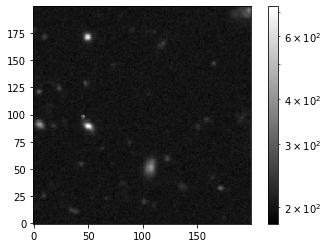

In [10]:
#E.stack(shifted=False, save_to_filename='mean_stack.fits')
E.stack(shifted=False)
plt.imshow((E.stacked_data.data-E.stacked_data.data.min())[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Combining images using median stacking.


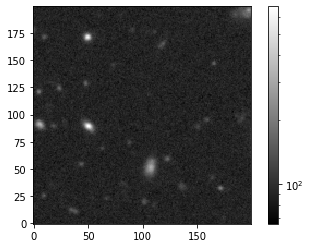

In [11]:
#E.stack(shifted=False, median_combine=True, save_to_filename='median_stack.fits')
E.stack(shifted=False, median_combine=True)
plt.imshow((E.stacked_data.data-E.stacked_data.data.min())[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Now define some an array of shifts and shift the data. _.integer_shift_ can take a _padmean=True_ keyword to pad the shifted data with the mean value instead of NaN.

In [12]:
#Different shifts whether we're using 12 or 24 images:
if both_nights:
    shifts=np.array([620, 505]) - np.array([np.concatenate([np.linspace(253, 329, 12),
                                                            np.linspace(542, 620, 12)]),
                                            np.concatenate([np.linspace(288, 332, 12),
                                                            np.linspace(459, 505, 12)])]
                                           ).round(0).astype(int).T
else:
    shifts=np.array([620, 505]) - np.array([np.linspace(542, 620, 12),
                                            np.linspace(459, 505, 12)]
                                           ).round(0).astype(int).T
print(shifts)
E.integer_shift(shifts, padmean=True)
#E.integer_shift(shifts, padmean=False)

[[78 46]
 [71 42]
 [64 38]
 [57 33]
 [50 29]
 [43 25]
 [35 21]
 [28 17]
 [21 13]
 [14  8]
 [ 7  4]
 [ 0  0]]
Shifting image 0 by [78 46]
Shifting image 1 by [71 42]
Shifting image 2 by [64 38]
Shifting image 3 by [57 33]
Shifting image 4 by [50 29]
Shifting image 5 by [43 25]
Shifting image 6 by [35 21]
Shifting image 7 by [28 17]
Shifting image 8 by [21 13]
Shifting image 9 by [14  8]
Shifting image 10 by [7 4]
Shifting image 11 by [0 0]


_E.shifted_data_ now contains the shifted image array, which is slightly larger than the original so as to not cut out anything:

In [13]:
print(E.data.shape)
print(E.shifted_data.shape)

(12, 4176, 2048)
(12, 4254, 2094)


Now stack and save, both mean and median stacking. Again, mean is better for photometric properties, but median removes more of the star signal.

Combining images using mean stacking


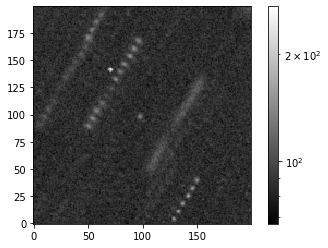

In [14]:
#E.stack(shifted=True, save_to_filename='shifted_mean_stack.fits')
E.stack(shifted=True)
plt.imshow((E.stacked_data.data-np.nanmin(E.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

Combining images using median stacking.


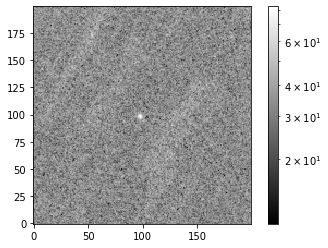

In [15]:
#E.stack(shifted=True, median_combine=True, save_to_filename='shifted_median_stack.fits')
E.stack(shifted=True, median_combine=True)
plt.imshow((E.stacked_data.data-np.nanmin(E.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()



This is just an experiment. One can subtrack the mean non-shifted image from each image before shifting and median-combining for even better cleaning. 

Combining images using mean stacking
Shifting image 0 by [78 46]
Shifting image 1 by [71 42]
Shifting image 2 by [64 38]
Shifting image 3 by [57 33]
Shifting image 4 by [50 29]
Shifting image 5 by [43 25]
Shifting image 6 by [35 21]
Shifting image 7 by [28 17]
Shifting image 8 by [21 13]
Shifting image 9 by [14  8]
Shifting image 10 by [7 4]
Shifting image 11 by [0 0]
Combining images using median stacking.
Saving stack to file shifted_median_stack_clean.fits
Done!


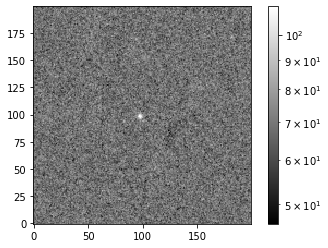

In [16]:
E=imagehandler.ImageEnsemble(filenames)
E.stack(shifted=False, median_combine=False)
E.data=np.array([E.data[i]-E.stacked_data.data for i in np.arange(len(E.data))])
E.integer_shift(shifts, padmean=True)
E.stack(shifted=True, median_combine=True, save_to_filename='shifted_median_stack_clean.fits')
plt.imshow((E.stacked_data.data-np.nanmin(E.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()

# Source Extractor Wrapper in Python (SEWPy)
Just a little playing around with _sewpy_. This should not go here in the end.

In [17]:
import sewpy
import importlib
importlib.reload(sewpy)
sew = sewpy.SEW(sexpath='sex',
                params=["X_IMAGE", "Y_IMAGE", "FLUX_AUTO", "FLUXERR_AUTO", "SNR_WIN",
                        "FWHM_IMAGE", "ELONGATION", "ISOAREAF_IMAGE", "FLAGS", "NUMBER"],
                config={"DETECT_MINAREA":10, "DETECT_THRESH":2.5, "ANALYSIS_THRESH":1.5})

Parameter 'SNR_WIN' seems strange and might be unknown to SExtractor
Known parameters are: 
#NUMBER                 Running object number                                     
#EXT_NUMBER             FITS extension number                                     
#FLUX_ISO               Isophotal flux                                             [count]
#FLUXERR_ISO            RMS error for isophotal flux                               [count]
#MAG_ISO                Isophotal magnitude                                        [mag]
#MAGERR_ISO             RMS error for isophotal magnitude                          [mag]
#FLUX_ISOCOR            Corrected isophotal flux                                   [count]
#FLUXERR_ISOCOR         RMS error for corrected isophotal flux                     [count]
#MAG_ISOCOR             Corrected isophotal magnitude                              [mag]
#MAGERR_ISOCOR          RMS error for corrected isophotal magnitude                [mag]
#FLUX_APER            

In [18]:
out = sew("shifted_median_stack_clean.fits")
out["table"] # this is an astropy table.

Ouch, SExtractor complains :
b''


X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUXERR_AUTO,SNR_WIN,FWHM_IMAGE,ELONGATION,ISOAREAF_IMAGE,FLAGS,NUMBER
pix,pix,ct,ct,,pix,,pix2,,
float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
1293.2117,358.414,2293.322,85.6837,30.3,6.25,1.925,18,2,1
503.8148,619.2891,861.3538,52.31776,26.68,4.02,1.179,24,0,2
806.8027,2560.1885,4432.628,153.8254,34.97,12.24,1.385,52,18,3
1029.0409,4050.8303,2614.12,104.2682,29.03,7.89,1.828,39,3,4
913.4262,4163.6973,880.0956,64.96796,18.35,5.44,2.139,10,0,5
1019.108,4077.0154,3083.613,153.7422,22.67,14.73,5.707,41,3,6
1019.2029,4055.3772,3634.945,122.0165,35.8,10.8,2.468,39,3,7
1016.2488,4066.8008,14465.7,376.1143,64.8,36.03,1.285,171,3,8


So, it's clearly pretty easy to get a SourceExtractor catalogue that has a very limited number of detections, of which only the known object has FLAGS==0. These are the flag bits:

    1	aperture photometry is likely to be biased by neighboring sources or
        by more than 10% of bad pixels in any aperture
    2	the object has been deblended
    4	at least one object pixel is saturated
    8	the isophotal footprint of the detected object is truncated (too close to an image boundary)
    16	at least one photometric aperture is incomplete or corrupted (hitting buffer or memory limits)
    32	the isophotal footprint is incomplete or corrupted (hitting buffer or memory limits)
    64	a memory overflow occurred during deblending
    128	a memory overflow occurred during extraction

So FLAGS==3 means both flags 1+2 apply. Anything with 2 or 3 is certainly bad, as it indicates it has found multiple sources right up against each other, so probably star/galaxy noise. I think anything with a 2 (or sum of 2 + other flag) can safely be ignored. Also, the detections can be filtered by ELONGATION and FWHM

In [19]:
idx=[(bin(o['FLAGS'])[-2]!='1') & (o['ELONGATION']<2) for o in out['table']]
good_sources=out['table'][idx]
good_sources

X_IMAGE,Y_IMAGE,FLUX_AUTO,FLUXERR_AUTO,SNR_WIN,FWHM_IMAGE,ELONGATION,ISOAREAF_IMAGE,FLAGS,NUMBER
pix,pix,ct,ct,,pix,,pix2,,
float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
503.8148,619.2891,861.3538,52.31776,26.68,4.02,1.179,24,0,2


There, easy peasy, get the source and nothing else :-)

















# Junk & testing
These things are here mostly as a reminder to myself about some of the functionality of various packages/classes that might be helpful to take advantage of. 

In [20]:
# A CCDData object can easily be constructed, as so:
dat = CCDData(one.data, wcs=one.WCS, header=one.header, unit='adu')
dat.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2048 / Axis length                                    
NAXIS2  =                 4176 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2017-01-13T08:51:18' / Date FITS file was generated                  
IRAF-TLM= '2017-01-13T08:51:17' / Time of last modification                     
OBJECT  = 'LF09    '           / Name of the object observed                    
BUNIT   = 'ADU     '           / Unit of original pixel value                   
BLANK   =               -32768 / Value used for NULL pixels                     
TIMESYS = 'UTC     '        

In [21]:
# wcs_reproject can take larger orders and a target_shape. 
# target_shape might be useful for preserving all the data, rather than trimming it to fit
# inside the shape of the target WCS. Need to investigate
reprojected_image=wcs_project(dat, E.WCS[0], order='bilinear', target_shape=(5000,5000))

Set DATE-END to '2016-08-27T15:03:43.582' from MJD-END'. [astropy.wcs.wcs]


In [22]:
E.WCS[0].all_pix2world([1,2,3], [1,1,1], 1)

[array([10.42161596, 10.42161597, 10.42161598]),
 array([6.67561299, 6.67556623, 6.67551947])]

In [23]:
# The centre pixels of a WCS can easily be changed, like so:
# This might be useful for propagating the WCS to the shift+stacked images,
# as those have a margin added to them, changing the center coordinate.
print(E.WCS[2])
E.WCS[1].wcs.crpix=(100,100)
print(E.WCS[2])
# NAXIS might also need to be changed.

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6433102502672  6.6284067186326  
CRPIX : 1013.65482257349  -4706.44029383452  
CD1_1 CD1_2  : 3.32711695566796e-08  -4.68837900701817e-05  
CD2_1 CD2_2  : -4.68837378893757e-05  -2.1688063379918e-08  
NAXIS : 2048  4176
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6433102502672  6.6284067186326  
CRPIX : 1013.65482257349  -4706.44029383452  
CD1_1 CD1_2  : 3.32711695566796e-08  -4.68837900701817e-05  
CD2_1 CD2_2  : -4.68837378893757e-05  -2.1688063379918e-08  
NAXIS : 2048  4176


In [24]:
E.stack(shifted=True, median_combine=True, save_to_filename='tst.fits')

Combining images using median stacking.
Saving stack to file tst.fits
Done!


In [25]:
%%time
E.save_stack()

Saving stack to file stack.fits
Done!
CPU times: user 27.3 ms, sys: 39.7 ms, total: 67 ms
Wall time: 65.6 ms


ie. we are not limited by writing files to disk. The shifting and especially the stacking is the time consuming part.